## Original formulation

In [ ]:
using DifferentialEquations
using IntervalArithmetic

using IntervalOptimisation #TODO
function f(du,u,p,t)
du[1] = p[1]u[1] - p[2]u[1]u[2] - p[5]u[1]^2
du[2] = -p[3]u[2] + p[4]u[1]*u[2]
end

u0 = [1.0, 1.0]
tspan = (0.0, 10.0)
p = [1.0, 1.0, 3.0, 1.0, 0.1]

p_int = (0.99..1.01) × (0.99..1.01) × (2.99..3.01) × (0.99..1.01) × (0.099..0.101)
u0_int = eltype(p_int).(u0)

prob = ODEProblem(f,u0_int,tspan,p) #TODO: swap p with p_int
sol = solve(prob,Tsit5(),adaptive=false,dt=0.0001)

This doesn't work because of wrapping effect etc.

## Flowpipe computation using a Taylor model approach

In [1]:
using ReachabilityAnalysis, Plots

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260


In [12]:
@taylorize function f(du, u, p, t)
    du[1] = (u[3] * u[1] - u[4] * (u[1] * u[2])) - u[7] * u[1]^2
    du[2] = -u[5] * u[2] + u[6] * (u[1] * u[2])
    
    # encode uncertain params
    du[3] = zero(u[1]) # p[1]
    du[4] = zero(u[1]) # p[2]
    du[5] = zero(u[1]) # p[3]
    du[6] = zero(u[1]) # p[4]
    du[7] = zero(u[1]) # p[5]
end

In [13]:
# encode initia-value problem
p_int = (0.99..1.01) × (0.99..1.01) × (2.99..3.01) × (0.99..1.01) × (0.099..0.101)
U0 = Singleton([1.0, 1.0]) × convert(Hyperrectangle, p_int)
prob = @ivp(u' = f(u), dim: 7, u(0) ∈ U0);

In [21]:
@time sol = solve(prob, tspan=(0.0, 10.0));

  4.989206 seconds (53.26 M allocations: 3.758 GiB, 32.02% gc time)


In [22]:
sol_zono = overapproximate(sol, Zonotope);
typeof(sol_zono)

ReachabilityAnalysis.ReachSolution{Flowpipe{Float64,ReachSet{Float64,Zonotope{Float64,Array{Float64,1},SubArray{Float64,2,SparseArrays.SparseMatrixCSC{Float64,Int64},Tuple{Base.Slice{Base.OneTo{Int64}},Array{Int64,1}},false}}}},TMJets{Float64}}

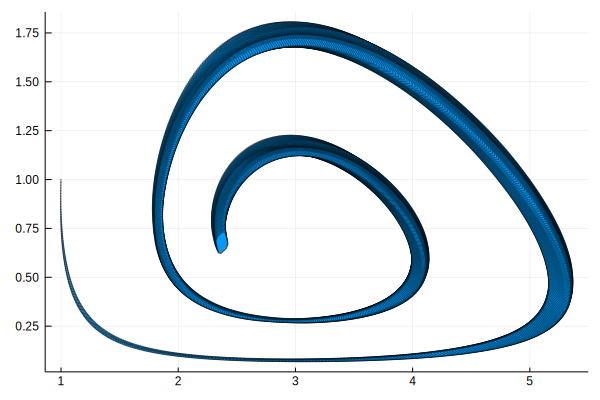

In [23]:
plot(sol_zono, vars=(1, 2))